### Relevant Libraries

In [150]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, normalized_mutual_info_score
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

### Well known KMeans class 

In [151]:
class KMeans:
    def __init__(self, X, K, max_iters=100, tol=1e-4):
        """
        Standard KMeans algorithm for clustering data points.

        Parameters:
        X : numpy.ndarray : Input data points
        K : int : Number of clusters
        max_iters : int : Maximum number of iterations for the algorithm
        tol : float : Tolerance for stopping the algorithm
        """
        self.X_data = X
        self.K_clusters = K
        self.max_iters = max_iters
        self.tol = tol
        self.centroids = None
        self.clusters = None

    def _initialize_centroids(self):
        """
        Initialize centroids by randomly selecting points from the data.
        """
        random_idx = np.random.choice(range(self.X_data.shape[0]), size=self.K_clusters, replace=False)
        self.centroids = self.X_data[random_idx]

    def _assign_clusters(self):
        """
        Assign each data point to the closest centroid.
        """
        self.clusters = [[] for _ in range(self.K_clusters)]
        for x in self.X_data:
            closest_idx = np.argmin(np.linalg.norm(x - self.centroids, axis=1))
            self.clusters[closest_idx].append(x)

    def _update_centroids(self):
        """
        Update centroids by calculating the mean of all points in each cluster.
        """
        new_centroids = []
        for cluster in self.clusters:
            if len(cluster) > 0:
                new_centroids.append(np.mean(cluster, axis=0))
        self.centroids = np.array(new_centroids)

    def fit(self):
        """
        Perform the KMeans clustering algorithm over a set number of iterations.
        """
        self._initialize_centroids()
        for _ in range(self.max_iters):
            self._assign_clusters()
            old_centroids = np.copy(self.centroids)
            self._update_centroids()
            # Check for convergence
            if np.all(np.linalg.norm(self.centroids - old_centroids, axis=1) < self.tol):
                break
        return self.centroids, self.clusters


The modified `CustomKMeans` algorithm improves upon the regular K-means by introducing a weighting mechanism:
$$
\text{centroid}_{k+1} = \frac{\sum \left( \frac{w_i}{d_i(\text{centroid}_k)} \cdot x_i \right)}{\sum \left( \frac{w_i}{d_i(\text{centroid}_k)} \right)}
$$
to update the centroids iteratively. The weights are computed based on the normalized distances:
$$
\text{weights} = 10^{-\frac{{\text{{distances}}}}{{\text{max(distances)}-\text{min(distances)}}}}
$$ between the cluster means and the individual samples within each cluster. The algorithm aims to minimize the mean distance between the samples and the weighted centroids.

This weighting approach allows the algorithm to assign higher importance to samples that are closer to the centroid, leading to more accurate centroid positions.


In [152]:
import numpy as np

class CustomKMeans:
    def __init__(self, X, K, max_iters=100, tol=1e-4):
        """
        Custom KMeans class that applies a centroid update with distance-based weighting.

        Parameters:
        X : numpy.ndarray : Input data points
        K : int : Number of clusters
        max_iters : int : Maximum number of iterations for the algorithm
        tol : float : Tolerance for stopping the algorithm when centroid movement is below this threshold
        """
        self.X_data = X
        self.K_clusters = K
        self.max_iters = max_iters
        self.tol = tol
        self.centroids = None
        self.clusters = None

    def _initialize_centroids(self):
        """
        Initialize centroids randomly from the data points.
        """
        random_idx = np.random.choice(range(self.X_data.shape[0]), size=self.K_clusters, replace=False)
        self.centroids = self.X_data[random_idx]

    def _assign_clusters(self):
        """
        Assign each data point to the closest centroid.
        """
        self.clusters = [[] for _ in range(self.K_clusters)]
        for x in self.X_data:
            closest_idx = np.argmin(np.linalg.norm(x - self.centroids, axis=1))
            self.clusters[closest_idx].append(x)

    def _update_centroids(self):
        """
        Update centroids using weighted means, adjusting for the distance from each point in the cluster.
        """
        new_centroids = []
        for cluster in self.clusters:
            cluster = np.array(cluster)
            if len(cluster) > 0:
                cluster_mean = np.mean(cluster, axis=0)
                distances = np.linalg.norm(cluster - cluster_mean, axis=-1) + 1e-9  # Avoid division by zero
                weights = 10 ** (-distances / (np.max(distances) - np.min(distances)))
                new_centroid = np.sum(weights[:, np.newaxis] * cluster, axis=0) / np.sum(weights)
                new_centroids.append(new_centroid)
        return np.array(new_centroids)

    def fit(self):
        """
        Perform the KMeans clustering algorithm over a set number of iterations or until convergence.
        """
        self._initialize_centroids()

        for _ in range(self.max_iters):
            self._assign_clusters()
            old_centroids = np.copy(self.centroids)
            self.centroids = self._update_centroids()

            # Check for convergence
            if np.all(np.linalg.norm(self.centroids - old_centroids, axis=1) < self.tol):
                break

        return self.centroids, self.clusters


### Fermat-Weber Method

The **Fermat-Weber method** is an iterative technique for finding the point (often called the "centroid") that minimizes the sum of **weighted Euclidean distances** to a given set of points. This point, sometimes referred to as the **Fermat-Weber point**, is an alternative to the arithmetic mean and is more robust in the presence of outliers. Given a set of points $ X_1, X_2, \dots, X_n $, the Fermat-Weber point $ P $ minimizes the following objective:

$$
\arg \min_P \sum_{i=1}^{n} w_i \|P - X_i\|
$$

where $ w_i $ are weights and $ \| \cdot \| $ represents the Euclidean distance. In each iteration, the position of $ P $ is updated based on the distances to the points $ X_i $, using a weighted average. This process continues until the movement of $ P $ between iterations falls below a given tolerance.


In [153]:
import numpy as np

class FermatWeberKMedians:
    def __init__(self, X, K, max_iters=100, tol=1e-4):
        """
        Fermat-Weber algorithm for clustering data by minimizing the sum of 
        weighted distances to points in each cluster.
        
        Parameters:
        X : numpy.ndarray : Input data points
        K : int : Number of clusters
        max_iters : int : Maximum number of iterations for the algorithm
        tol : float : Tolerance for stopping the algorithm when centroid movement is below this threshold
        """
        self.X_data = X
        self.K_clusters = K
        self.max_iters = max_iters
        self.tol = tol
        self.centroids = None
        self.clusters = None

    def _initialize_centroids(self):
        """
        Initialize centroids by randomly selecting points from the data.
        """
        random_idx = np.random.choice(range(self.X_data.shape[0]), size=self.K_clusters, replace=False)
        self.centroids = self.X_data[random_idx]

    def _assign_clusters(self):
        """
        Assign each data point to the closest centroid based on Euclidean distance.
        """
        self.clusters = [[] for _ in range(self.K_clusters)]
        for x in self.X_data:
            # Assign point to the nearest centroid
            closest_idx = np.argmin(np.linalg.norm(x - self.centroids, axis=1))
            self.clusters[closest_idx].append(x)

    def _update_centroids(self):
        """
        Update centroids by minimizing the sum of weighted distances to the points in each cluster.
        The weights are inversely proportional to the distances.
        """
        new_centroids = []
        for idx, cluster in enumerate(self.clusters):
            if len(cluster) > 0:
                cluster = np.array(cluster)
                current_centroid = self.centroids[idx]  # Use the current centroid as the starting point
                # Calculate distances from the current centroid to each point in the cluster
                distances = np.linalg.norm(cluster - current_centroid, axis=-1) + 1e-9  # Avoid division by zero
                # Inverse of distances to determine weights
                weights = 1 / distances
                # Update centroid using the weighted sum of points
                new_centroid = np.sum(weights[:, np.newaxis] * cluster, axis=0) / np.sum(weights)
                new_centroids.append(new_centroid)
        self.centroids = np.array(new_centroids)

    def fit(self):
        """
        Perform the Fermat-Weber clustering algorithm by iteratively updating centroids 
        to minimize the sum of weighted distances to the points in the cluster.
        """
        self._initialize_centroids()
        for _ in range(self.max_iters):
            self._assign_clusters()
            old_centroids = np.copy(self.centroids)
            self._update_centroids()
            # Check for convergence based on the change in centroid positions
            if np.all(np.linalg.norm(self.centroids - old_centroids, axis=1) < self.tol):
                break
        return self.centroids, self.clusters


### Weiszfeld Algorithm

The **Weiszfeld algorithm** is an iterative method for finding the **geometric median**, which serves as the center (or "centroid") in this context. The geometric median minimizes the sum of weighted Euclidean distances to all points in a dataset, making it a robust alternative to the traditional arithmetic centroid used in KMeans (the mean). Given a set of points $ X_1, X_2, \dots, X_n $, the geometric median $ P $ minimizes:

$$
\arg \min_P \sum_{i=1}^{n} w_i \|P - X_i\|
$$

where $ w_i $ are weights and $ \| \cdot \| $ represents the Euclidean distance. The Weiszfeld algorithm iteratively updates $ P $ (the geometric median) as:

$$
P_{k+1} = \frac{\sum_{i=1}^{n} \frac{w_i X_i}{\|P_k - X_i\|}}{\sum_{i=1}^{n} \frac{w_i}{\|P_k - X_i\|}}
$$

This update process continues until the movement of $ P $ between iterations is below a set tolerance.

In general, The **FermatWeberAlgorithm** updates centroids using inverse distances to points, effectively following the Fermat-Weber method for clustering, while the **WeiszfeldAlgorithm** directly finds the geometric median (Fermat-Weber point) for a set of points without clustering.


In both the **Weiszfeld algorithm** and the **Fermat-Weber method**, the weights assigned to each point during the update of the centroid (or geometric median) are inversely proportional to the distances between the points and the current centroid. Specifically, the weights are calculated as:

$$
w_i = \frac{1}{\|P - X_i\|  + \epsilon}
$$

where:
- $ P $ is the current centroid (or geometric median),
- $ X_i $ is the data point,
- $ \|P - X_i\| $ is the Euclidean distance between the centroid and the point $ X_i $.
- Adding $\epsilon$ ensures that the division is well defined.

These **weights** ensure that points closer to the centroid have a higher influence on its position, while points farther away (especially outliers) have less influence. This approach makes the algorithms robust to outliers, as distant points contribute less to the centroid update. The weighted sum is then used to iteratively update the centroid (or geometric median) until convergence is achieved.


In [154]:
class WeiszfeldKMedians:
    def __init__(self, X, K, max_iters=100, tol=1e-4):
        """
        Weiszfeld algorithm for K-medians clustering (finding multiple geometric medians).
        
        Parameters:
        X : numpy.ndarray : Input data points
        K : int : Number of clusters (medians)
        max_iters : int : Maximum number of iterations for convergence
        tol : float : Tolerance for centroid convergence
        """
        self.X_data = X
        self.K_clusters = K
        self.max_iters = max_iters
        self.tol = tol
        self.medians = None
        self.clusters = None

    def _initialize_medians(self):
        """
        Initialize K medians by randomly selecting points from the dataset.
        """
        random_idx = np.random.choice(range(self.X_data.shape[0]), size=self.K_clusters, replace=False)
        self.medians = self.X_data[random_idx]

    def _assign_clusters(self):
        """
        Assign each data point to the closest median (geometric median).
        """
        self.clusters = [[] for _ in range(self.K_clusters)]
        for x in self.X_data:
            closest_idx = np.argmin(np.linalg.norm(x - self.medians, axis=1))
            self.clusters[closest_idx].append(x)

    def _weiszfeld_update(self, cluster, median, epsilon=1e-9):
        """
        Perform one iteration of the Weiszfeld algorithm for a single cluster.
        
        Parameters:
        cluster : numpy.ndarray : The points in the current cluster
        median : numpy.ndarray : The current median for this cluster
        epsilon : float : Small value to prevent division by zero
        """
        for _ in range(self.max_iters):
            distances = np.linalg.norm(cluster - median, axis=1)
            weights = 1 / (distances + epsilon)  # Inverse of distances to prevent division by zero
            new_median = np.sum(weights[:, np.newaxis] * cluster, axis=0) / np.sum(weights)
            if np.linalg.norm(new_median - median) < self.tol:
                break
            median = new_median
        return median

    def _update_medians(self):
        """
        Update the medians for all clusters using the Weiszfeld algorithm.
        """
        new_medians = []
        for idx, cluster in enumerate(self.clusters):
            if len(cluster) > 0:
                cluster = np.array(cluster)
                current_median = self.medians[idx]
                new_median = self._weiszfeld_update(cluster, current_median)
                new_medians.append(new_median)
        self.medians = np.array(new_medians)

    def fit(self):
        """
        Perform K-medians clustering using the Weiszfeld algorithm to iteratively update the medians.
        """
        self._initialize_medians()
        for _ in range(self.max_iters):
            self._assign_clusters()
            old_medians = np.copy(self.medians)
            self._update_medians()
            # Check for convergence based on the movement of the medians
            if np.all(np.linalg.norm(self.medians - old_medians, axis=1) < self.tol):
                break
        return self.medians, self.clusters


### Data Preparation

In [155]:
# Separated Data
np.random.seed(0)
group1 = np.random.normal(loc=0, scale=1, size=(30, 2))
group2 = np.random.normal(loc=10, scale=1, size=(30, 2))
group3 = np.random.normal(loc=30, scale=1, size=(30, 2))
group4 = np.random.normal(loc=50, scale=1, size=(30, 2))

data_separated = np.concatenate((group1, group2, group3, group4))

# Non-Separated Data
np.random.seed(0)
group1 = np.random.normal(loc=0, scale=1, size=(30, 2))
group2 = np.random.normal(loc=5, scale=1, size=(30, 2))
group3 = np.random.normal(loc=-5, scale=1, size=(30, 2))
group4 = np.random.normal(loc=8.5, scale=1, size=(30, 2))
outlier_group = np.random.normal(loc=10, scale=20, size=(5, 2))

data_non_separated = np.concatenate((group1, group2, group3, group4, outlier_group))


### Performance Evaluation Functions

In [156]:
def evaluate_performance(X, centroids, clusters, true_labels):
    """
    Calculate Silhouette Score, Davies-Bouldin Index, Calinski-Harabasz Index, and NMI.
    """
    labels = np.zeros(len(X), dtype=int)
    for i, cluster in enumerate(clusters):
        for point in cluster:
            idx = np.where((X == point).all(axis=1))[0][0]
            labels[idx] = i

    # Silhouette Score
    silhouette_avg = silhouette_score(X, labels)
    
    # Davies-Bouldin Index (lower is better)
    davies_bouldin = davies_bouldin_score(X, labels)
    
    # Calinski-Harabasz Index (higher is better)
    calinski_harabasz = calinski_harabasz_score(X, labels)
    
    # Normalized Mutual Information (NMI) with true labels
    nmi = normalized_mutual_info_score(true_labels, labels)

    return silhouette_avg, davies_bouldin, calinski_harabasz, nmi


# Adding True Labels for NMI, since the data is synthetic we already know how the data is grouped
# Define true labels for separated data (0, 1, 2, 3 for each group)
true_labels_separated = np.concatenate([np.full(30, i) for i in range(4)])

# Define true labels for non-separated data
true_labels_non_separated = np.concatenate([np.full(30, i) for i in range(4)] + [np.full(5, 4)])  # Outliers as class 4


### Evaluating the models

In [157]:
# Initialize models for separated data
kmeans_separated = KMeans(data_separated, K=4)
custom_kmeans_separated = CustomKMeans(data_separated, K=4)
fermat_weber_separated = FermatWeberKMedians(data_separated, K=4)
weiszfeld_separated = WeiszfeldKMedians(data_separated, K=4)

# Fit the models and get centroids and clusters
centroids_kmeans, clusters_kmeans = kmeans_separated.fit()
centroids_custom, clusters_custom = custom_kmeans_separated.fit()
centroids_fw, clusters_fw = fermat_weber_separated.fit()
centroids_wz, clusters_wz = weiszfeld_separated.fit()

# Evaluate performance on separated data
silhouette_kmeans_sep, dbi_kmeans_sep, ch_kmeans_sep, nmi_kmeans_sep = evaluate_performance(
    data_separated, centroids_kmeans, clusters_kmeans, true_labels_separated
)
silhouette_custom_sep, dbi_custom_sep, ch_custom_sep, nmi_custom_sep = evaluate_performance(
    data_separated, centroids_custom, clusters_custom, true_labels_separated
)
silhouette_fw_sep, dbi_fw_sep, ch_fw_sep, nmi_fw_sep = evaluate_performance(
    data_separated, centroids_fw, clusters_fw, true_labels_separated
)
silhouette_wz_sep, dbi_wz_sep, ch_wz_sep, nmi_wz_sep = evaluate_performance(
    data_separated, centroids_wz, clusters_wz, true_labels_separated
)


# Initialize models for non-separated data
kmeans_non_separated = KMeans(data_non_separated, K=4)
custom_kmeans_non_separated = CustomKMeans(data_non_separated, K=4)
fermat_weber_non_separated = FermatWeberKMedians(data_non_separated, K=4)
weiszfeld_non_separated = WeiszfeldKMedians(data_non_separated, K=4)

# Fit the models and get centroids and clusters
centroids_kmeans_ns, clusters_kmeans_ns = kmeans_non_separated.fit()
centroids_custom_ns, clusters_custom_ns = custom_kmeans_non_separated.fit()
centroids_fw_ns, clusters_fw_ns = fermat_weber_non_separated.fit()
centroids_wz_ns, clusters_wz_ns = weiszfeld_non_separated.fit()

# Evaluate performance on non-separated data
silhouette_kmeans_ns, dbi_kmeans_ns, ch_kmeans_ns, nmi_kmeans_ns = evaluate_performance(
    data_non_separated, centroids_kmeans_ns, clusters_kmeans_ns, true_labels_non_separated
)
silhouette_custom_ns, dbi_custom_ns, ch_custom_ns, nmi_custom_ns = evaluate_performance(
    data_non_separated, centroids_custom_ns, clusters_custom_ns, true_labels_non_separated
)
silhouette_fw_ns, dbi_fw_ns, ch_fw_ns, nmi_fw_ns = evaluate_performance(
    data_non_separated, centroids_fw_ns, clusters_fw_ns, true_labels_non_separated
)
silhouette_wz_ns, dbi_wz_ns, ch_wz_ns, nmi_wz_ns = evaluate_performance(
    data_non_separated, centroids_wz_ns, clusters_wz_ns, true_labels_non_separated
)


### Displaying the Metrics

In [158]:
# Display results for separated data
metrics_separated = {
    'Algorithm': ['KMeans', 'CustomKMeans', 'FermatWeberKMedians', 'WeiszfeldKMedians'], 
    'Silhouette Score': [silhouette_kmeans_sep, silhouette_custom_sep, silhouette_fw_sep, silhouette_wz_sep],
    'Davies-Bouldin Index': [dbi_kmeans_sep, dbi_custom_sep, dbi_fw_sep, dbi_wz_sep],
    'Calinski-Harabasz Index': [ch_kmeans_sep, ch_custom_sep, ch_fw_sep, ch_wz_sep],
    'NMI': [nmi_kmeans_sep, nmi_custom_sep, nmi_fw_sep, nmi_wz_sep]
}

df_metrics_sep = pd.DataFrame(metrics_separated)

# Displaying the metrics in Jupyter
html_title_sep = "<h2>Performance Comparison on Separated Data</h2>"
df_html_sep = html_title_sep + df_metrics_sep.to_html(index=False)
display(HTML(df_html_sep))


Algorithm,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,NMI
KMeans,0.570642,0.929926,242.571246,0.800687
CustomKMeans,0.903273,0.134421,14523.462463,1.000000
FermatWeberKMedians,0.338425,0.839399,224.675486,0.726114
WeiszfeldKMedians,0.187024,2.514328,211.985499,0.569861


In [159]:
# Display results for non-separated data
metrics_non_separated = {
    'Algorithm': ['KMeans', 'CustomKMeans', 'FermatWeberKMedians', 'WeiszfeldKMedians'], 
    'Silhouette Score': [silhouette_kmeans_ns, silhouette_custom_ns, silhouette_fw_ns, silhouette_wz_ns],
    'Davies-Bouldin Index': [dbi_kmeans_ns, dbi_custom_ns, dbi_fw_ns, dbi_wz_ns],
    'Calinski-Harabasz Index': [ch_kmeans_ns, ch_custom_ns, ch_fw_ns, ch_wz_ns],
    'NMI': [nmi_kmeans_ns, nmi_custom_ns, nmi_fw_ns, nmi_wz_ns]
}

df_metrics_ns = pd.DataFrame(metrics_non_separated)

# Displaying the metrics in Jupyter
html_title_ns = "<h2>Performance Comparison on Non-Separated Data</h2>"
df_html_ns = html_title_ns + df_metrics_ns.to_html(index=False)
display(HTML(df_html_ns))


Algorithm,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,NMI
KMeans,0.501290,0.456997,177.933406,0.696223
CustomKMeans,0.522352,0.954566,124.828006,0.750253
FermatWeberKMedians,0.401144,0.713953,116.473917,0.750895
WeiszfeldKMedians,0.352704,0.792708,104.364159,0.708963


### Plotting

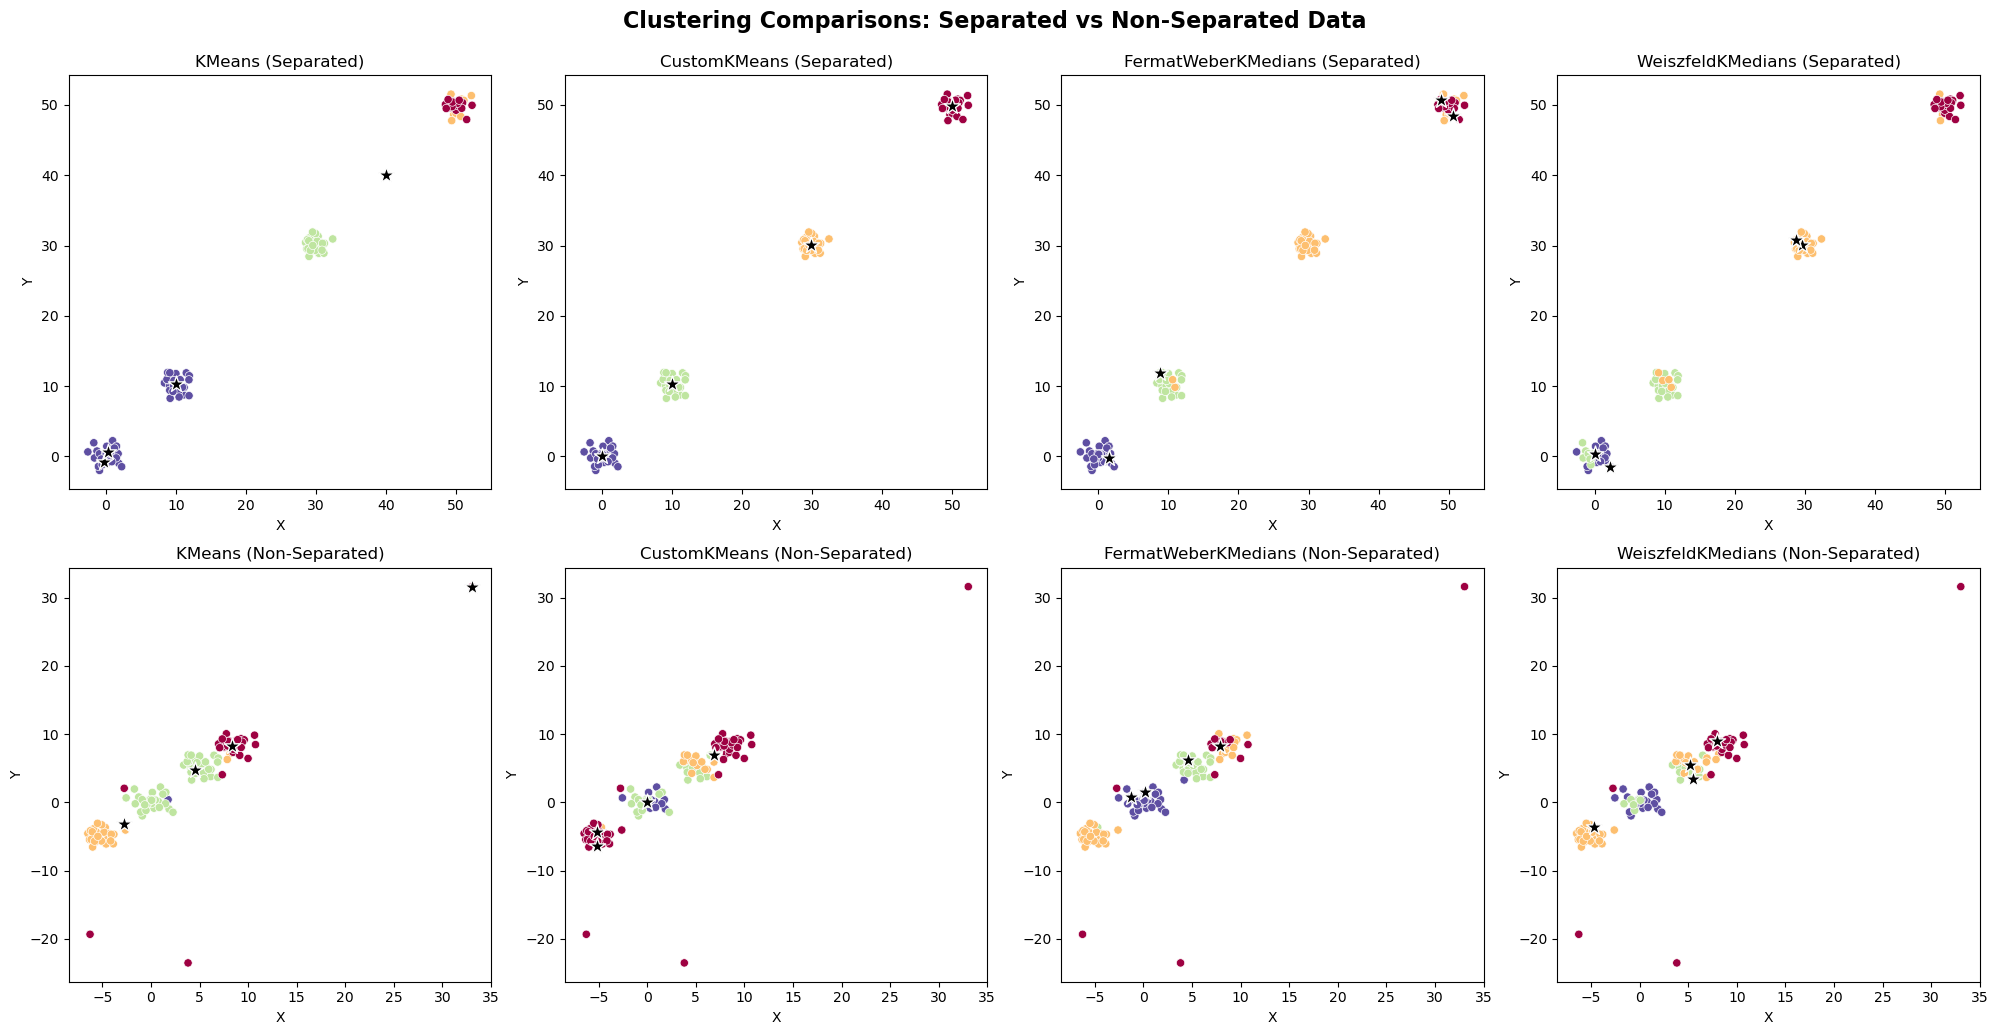

In [160]:
def plot_clusters(data, centroids, clusters, title, ax):
    """
    Plot the clusters and centroids on the given axis.
    
    Parameters:
    data : numpy.ndarray : Input data points
    centroids : numpy.ndarray : Centroids of the clusters
    clusters : List[List] : Clustered points
    title : str : Title of the plot
    ax : Matplotlib axis : The axis to plot on
    """
    df = pd.DataFrame(data, columns=['X', 'Y'])
    df['Cluster'] = [i+1 for i, sublist in enumerate(clusters) for _ in sublist]
    
    # Plot the data points and centroids
    sns.scatterplot(data=df, x='X', y='Y', hue='Cluster', palette='Spectral_r', ax=ax, legend=None)
    sns.scatterplot(data=pd.DataFrame(centroids, columns=['X', 'Y']), x='X', y='Y', color='black', marker='*', legend=False, s=150, ax=ax)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title, fontsize=12)

# Create subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows (separated/non-separated), 4 columns (one for each model)

# Plot for separated data
plot_clusters(data_separated, centroids_kmeans, clusters_kmeans, 'KMeans (Separated)', axes[0, 0])
plot_clusters(data_separated, centroids_custom, clusters_custom, 'CustomKMeans (Separated)', axes[0, 1])
plot_clusters(data_separated, centroids_fw, clusters_fw, 'FermatWeberKMedians (Separated)', axes[0, 2])
plot_clusters(data_separated, centroids_wz, clusters_wz, 'WeiszfeldKMedians (Separated)', axes[0, 3])

# Plot for non-separated data
plot_clusters(data_non_separated, centroids_kmeans_ns, clusters_kmeans_ns, 'KMeans (Non-Separated)', axes[1, 0])
plot_clusters(data_non_separated, centroids_custom_ns, clusters_custom_ns, 'CustomKMeans (Non-Separated)', axes[1, 1])
plot_clusters(data_non_separated, centroids_fw_ns, clusters_fw_ns, 'FermatWeberKMedians (Non-Separated)', axes[1, 2])
plot_clusters(data_non_separated, centroids_wz_ns, clusters_wz_ns, 'WeiszfeldKMedians (Non-Separated)', axes[1, 3])

# Adjust layout for better spacing
plt.tight_layout()

# Set the main title
plt.suptitle('Clustering Comparisons: Separated vs Non-Separated Data', fontsize=16, fontweight='bold', y=1.03)

# Show plot
plt.show()
